In [9]:
import numpy as np 
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [10]:
df=pd.read_csv("https://raw.githubusercontent.com/Vinsocf/emotions/main/Wisconsin-bc-data.csv")
# will change the repository 

In [63]:
x=df.drop(['Unnamed: 32','id','diagnosis'],axis=1)
y=df['diagnosis']

# **Feature selection with correlation**

In [12]:
drop_list_cor = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = x.drop(drop_list_cor,axis = 1 )        
x_1.head()
selected_feature_corr=x_1.columns
fs_corr = np.ones(len(x_1.columns)).astype(int)
fs_corr = pd.DataFrame(fs_corr, columns = ["Corr"], index=x_1.columns)
fs_corr

,Corr
texture_mean,1
area_mean,1
smoothness_mean,1
concavity_mean,1
symmetry_mean,1
fractal_dimension_mean,1
texture_se,1
area_se,1
smoothness_se,1
concavity_se,1


In [13]:
fs_corr = fs_corr.reset_index()

In [14]:
fs_corr.head()

,index,Corr
0,texture_mean,1
1,area_mean,1
2,smoothness_mean,1
3,concavity_mean,1
4,symmetry_mean,1


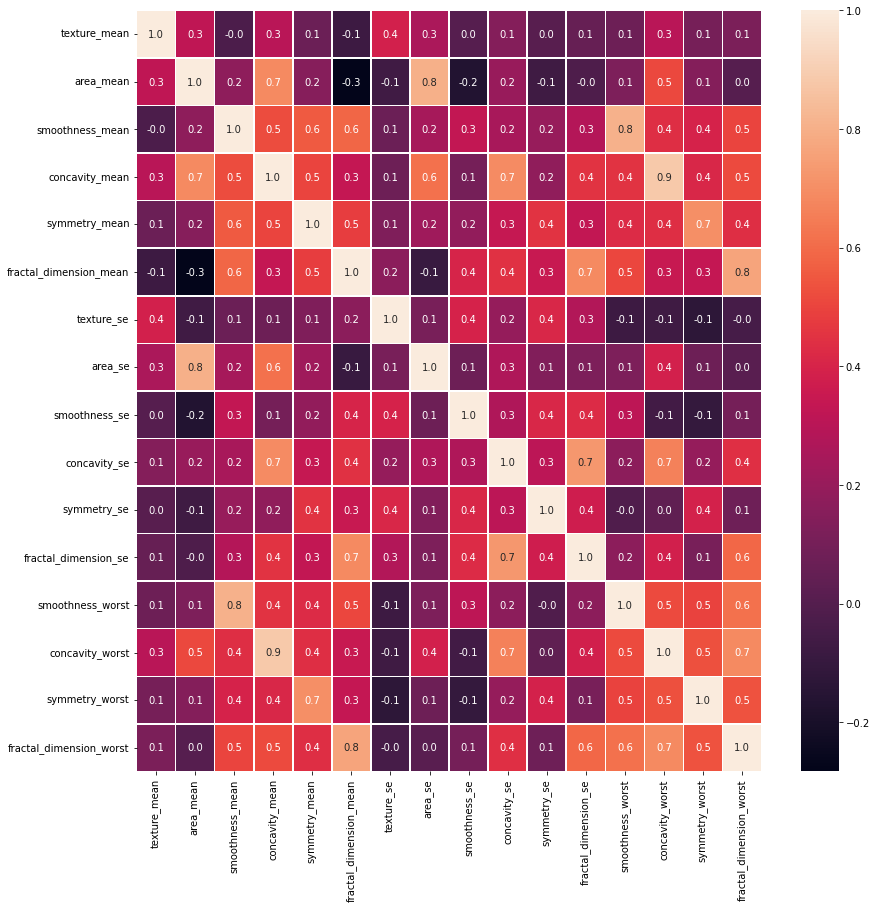

In [15]:
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Accuracy is:  0.9649122807017544


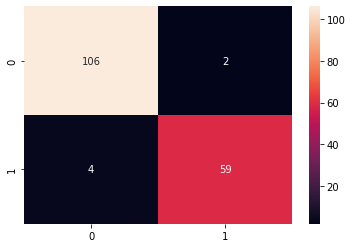

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")


# **Univariate feature selection (Chi-square)**

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select_feature = SelectKBest(chi2, k=10).fit(x_train, y_train)


In [18]:
import numpy
numpy.set_printoptions(suppress=True)
print('Score list:', select_feature.scores_)

Score list: [   60.69164331 36689.9556596      0.10001518    13.05476497
     0.19598285     0.00034258     0.0407131   6127.41067039
     0.0013247      0.69289672     0.00139558     0.00265927
     0.26322631    25.88581167     1.00635138     0.12308735]


In [19]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
fs_chi2 = pd.DataFrame(select_feature.scores_, columns = ["Chi_Square"], index=x_train.columns)

In [20]:
fs_chi2 = fs_chi2.reset_index()

In [21]:
fs_chi2 = fs_chi2.sort_values('Chi_Square',ascending=0)
fs_chi2

,index,Chi_Square
1,area_mean,36689.96
7,area_se,6127.41
0,texture_mean,60.69
13,concavity_worst,25.89
3,concavity_mean,13.05
14,symmetry_worst,1.01
9,concavity_se,0.69
12,smoothness_worst,0.26
4,symmetry_mean,0.20
15,fractal_dimension_worst,0.12


# **Recursive feature elimination (RFE) with random forest**

In [22]:
from sklearn.feature_selection import RFE
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=10, step=1)
rfe = rfe.fit(x_train, y_train)


In [23]:
fs_rfe = DataFrame(rfe.support_, columns = ["RFE"], index=x_train.columns)
fs_rfe = fs_rfe.reset_index()
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(x_train.columns[rfe.support_])))
print('Chosen best 10 feature by rfe:',x_train.columns[rfe.support_])

total features: 16
selected features: 10
Chosen best 10 feature by rfe: Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'concavity_se', 'smoothness_worst',
       'concavity_worst', 'symmetry_worst'],
      dtype='object')


In [24]:
from sklearn.feature_selection import RFECV

clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)


In [25]:
fs_rfecv = DataFrame(rfecv.support_, columns = ["RFECV"], index=x_train.columns)
fs_rfecv = fs_rfecv.reset_index()
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(x_train.columns[rfecv.support_])))
print('Optimal number of features :', rfecv.n_features_)
print('Best features by rfecv:',x_train.columns[rfecv.support_])

total features: 16
selected features: 8
Optimal number of features : 8
Best features by rfecv: Index(['texture_mean', 'area_mean', 'concavity_mean', 'area_se',
       'concavity_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst'],
      dtype='object')


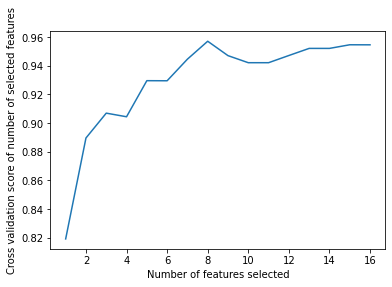

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# **Tree based feature selection and random forest classification**

Feature ranking:
1. feature 3 (0.232390)
2. feature 1 (0.208603)
3. feature 13 (0.146399)
4. feature 7 (0.131118)
5. feature 0 (0.046548)
6. feature 14 (0.046296)
7. feature 9 (0.039968)
8. feature 12 (0.034851)
9. feature 5 (0.019015)
10. feature 11 (0.016392)
11. feature 15 (0.015056)
12. feature 10 (0.013999)
13. feature 2 (0.013764)
14. feature 8 (0.013002)
15. feature 6 (0.012810)
16. feature 4 (0.009791)


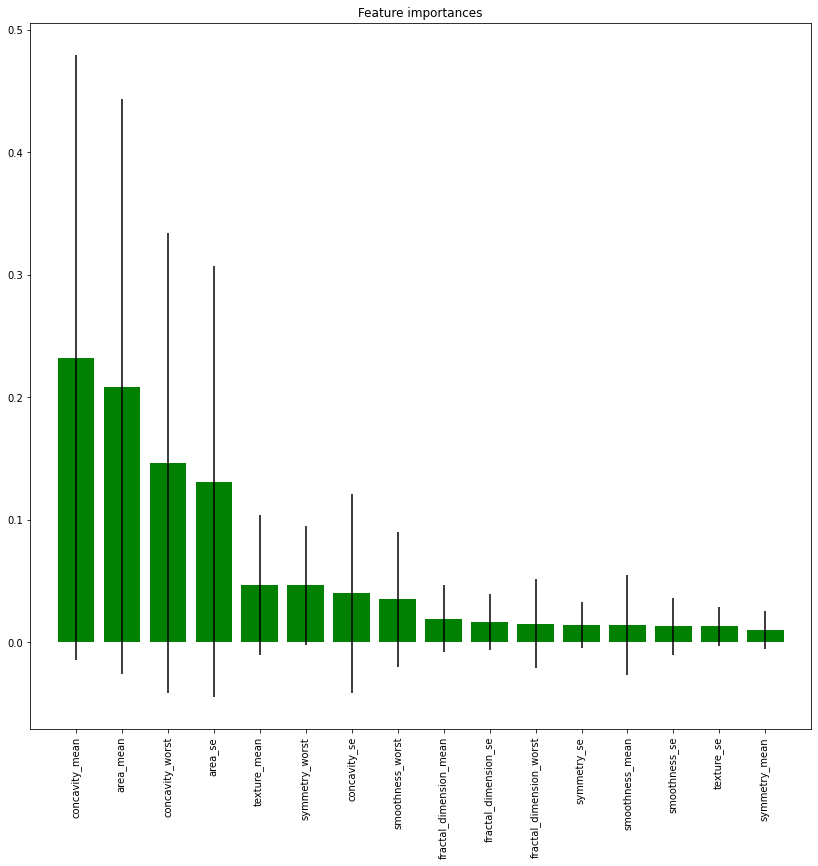

In [27]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()


In [28]:
indices = np.argsort(importances)[::-1]
indices
importances[indices]

array([0.23239003, 0.20860255, 0.14639865, 0.1311184 , 0.04654823,
       0.04629579, 0.03996755, 0.03485064, 0.01901509, 0.01639181,
       0.01505569, 0.0139991 , 0.01376424, 0.01300165, 0.01280988,
       0.0097907 ])

In [29]:
fs_rf = DataFrame(clr_rf_5.feature_importances_, columns = ["RF"], index=x_train.columns)
fs_rf = fs_rf.reset_index()

In [30]:
fs_rf = fs_rf.sort_values('RF',ascending=0)
fs_rf

,index,RF
3,concavity_mean,0.23
1,area_mean,0.21
13,concavity_worst,0.15
7,area_se,0.13
0,texture_mean,0.05
14,symmetry_worst,0.05
9,concavity_se,0.04
12,smoothness_worst,0.03
5,fractal_dimension_mean,0.02
11,fractal_dimension_se,0.02


# **L1-based feature selection (LinearSVC)**

In [31]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False,max_iter=2000).fit(x_train, y_train) 
model = SelectFromModel(lsvc, prefit=True) 
x_new = model.transform(x_train) 
print(x_train.columns[model.get_support()])

Index(['texture_mean', 'area_mean', 'area_se'], dtype='object')


In [32]:
fs_l1 = DataFrame(model.get_support(), columns = ["L1"], index=x_train.columns)
fs_l1 = fs_l1.reset_index()
selected_feature_lsvc = x_train.columns[model.get_support()]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feature_lsvc)))
print('Best features by lsvc:',x_train.columns[model.get_support()])

total features: 16
selected features: 3
Best features by lsvc: Index(['texture_mean', 'area_mean', 'area_se'], dtype='object')


# **Tree-based feature selection (ExtraTrees)**

Feature ranking:
1. feature 3 (0.191527)
2. feature 1 (0.170634)
3. feature 13 (0.169116)
4. feature 7 (0.123651)
5. feature 0 (0.056858)
6. feature 14 (0.039312)
7. feature 12 (0.035452)
8. feature 15 (0.032071)
9. feature 9 (0.030526)
10. feature 5 (0.029508)
11. feature 4 (0.028988)
12. feature 2 (0.022375)
13. feature 11 (0.020679)
14. feature 10 (0.017656)
15. feature 6 (0.016700)
16. feature 8 (0.014947)


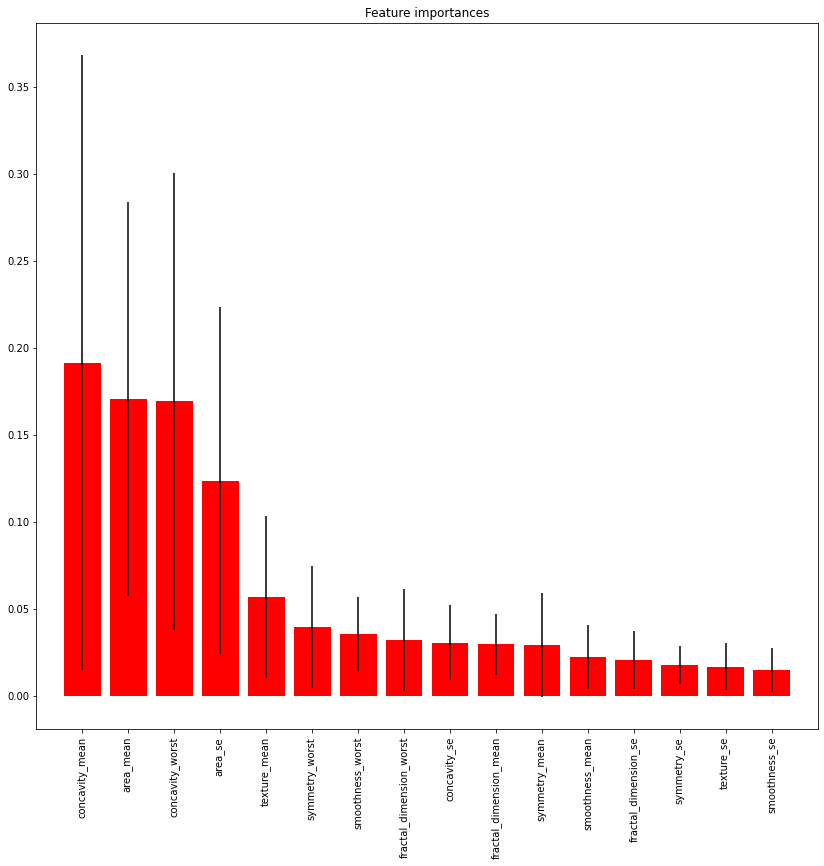

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=32,random_state=0)
clf.fit(x_train, y_train)
clf.feature_importances_ 
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()


In [34]:
selected_feature_extraTrees = x_train.columns[model.get_support()]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feature_extraTrees)))
print('Best features by ExtraTrees:',x_train.columns[model.get_support()])

total features: 16
selected features: 3
Best features by ExtraTrees: Index(['texture_mean', 'area_mean', 'area_se'], dtype='object')


In [35]:
fs_extratrees=DataFrame(clf.feature_importances_, columns = ["Extratrees"], index=x_train.columns)

In [36]:
fs_extratrees = fs_extratrees.reset_index()

In [37]:
fs_extratrees = fs_extratrees.sort_values(['Extratrees'],ascending=0)
fs_extratrees

,index,Extratrees
3,concavity_mean,0.19
1,area_mean,0.17
13,concavity_worst,0.17
7,area_se,0.12
0,texture_mean,0.06
14,symmetry_worst,0.04
12,smoothness_worst,0.04
15,fractal_dimension_worst,0.03
9,concavity_se,0.03
5,fractal_dimension_mean,0.03


# **Vote based feature selection**

In [38]:
fs_extratrees.shape

(16, 2)

In [39]:
from functools import reduce
dfs = [fs_corr, fs_chi2, fs_rfe, fs_rfecv, fs_rf, fs_l1, fs_extratrees]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [40]:
final_results.head()

,index,Corr,Chi_Square,RFE,RFECV,RF,L1,Extratrees
0,texture_mean,1,60.69,True,True,0.05,True,0.06
1,area_mean,1,36689.96,True,True,0.21,True,0.17
2,smoothness_mean,1,0.10,True,False,0.01,False,0.02
3,concavity_mean,1,13.05,True,True,0.23,False,0.19
4,symmetry_mean,1,0.20,False,False,0.01,False,0.03


In [41]:
final_results.columns

Index(['index', 'Corr', 'Chi_Square', 'RFE', 'RFECV', 'RF', 'L1',
       'Extratrees'],
      dtype='object')

In [42]:
columns = ['Chi_Square', 'RF', 'Extratrees']
score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']
for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(10,i)['index'])).astype(int)

score_table['RFE'] = final_results['RFE'].astype(int)
score_table['RFECV'] = final_results['RFECV'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [43]:
score_table['final_score'] = score_table.sum(axis=1)

In [44]:
score_table.sort_values('final_score',ascending=0)

,index,Chi_Square,RF,Extratrees,RFE,RFECV,L1,final_score
0,texture_mean,1,1,1,1,1,1,6
1,area_mean,1,1,1,1,1,1,6
7,area_se,1,1,1,1,1,1,6
3,concavity_mean,1,1,1,1,1,0,5
9,concavity_se,1,1,1,1,1,0,5
12,smoothness_worst,1,1,1,1,1,0,5
13,concavity_worst,1,1,1,1,1,0,5
14,symmetry_worst,1,1,1,1,1,0,5
5,fractal_dimension_mean,0,1,1,1,0,0,3
15,fractal_dimension_worst,1,0,1,0,0,0,2


In [45]:
list(score_table['index'][score_table['final_score']>=2])

['texture_mean',
 'area_mean',
 'concavity_mean',
 'fractal_dimension_mean',
 'area_se',
 'concavity_se',
 'smoothness_worst',
 'concavity_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [46]:
list(score_table['index'][score_table['RFE']==1])

['texture_mean',
 'area_mean',
 'smoothness_mean',
 'concavity_mean',
 'fractal_dimension_mean',
 'area_se',
 'concavity_se',
 'smoothness_worst',
 'concavity_worst',
 'symmetry_worst']

In [47]:
list(score_table['index'][score_table['RFECV']==1])

['texture_mean',
 'area_mean',
 'concavity_mean',
 'area_se',
 'concavity_se',
 'smoothness_worst',
 'concavity_worst',
 'symmetry_worst']

In [48]:
list(score_table['index'][score_table['Chi_Square']==1])

['texture_mean',
 'area_mean',
 'concavity_mean',
 'symmetry_mean',
 'area_se',
 'concavity_se',
 'smoothness_worst',
 'concavity_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [49]:
list(score_table['index'][score_table['RF']==1])

['texture_mean',
 'area_mean',
 'concavity_mean',
 'fractal_dimension_mean',
 'area_se',
 'concavity_se',
 'fractal_dimension_se',
 'smoothness_worst',
 'concavity_worst',
 'symmetry_worst']

In [50]:
list(score_table['index'][score_table['L1']==1])

['texture_mean', 'area_mean', 'area_se']

In [51]:
list(score_table['index'][score_table['Extratrees']==1])

['texture_mean',
 'area_mean',
 'concavity_mean',
 'fractal_dimension_mean',
 'area_se',
 'concavity_se',
 'smoothness_worst',
 'concavity_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [53]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [54]:
vif = calculate_vif(x_train)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    x_train.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(x_train)

In [55]:
vif

,Features,VIF
0,texture_se,7.74
1,area_se,2.01
2,smoothness_se,7.33
3,concavity_se,4.11
4,symmetry_se,8.41
5,concavity_worst,4.46


Text(0, 0.5, 'explained_variance_ratio_')

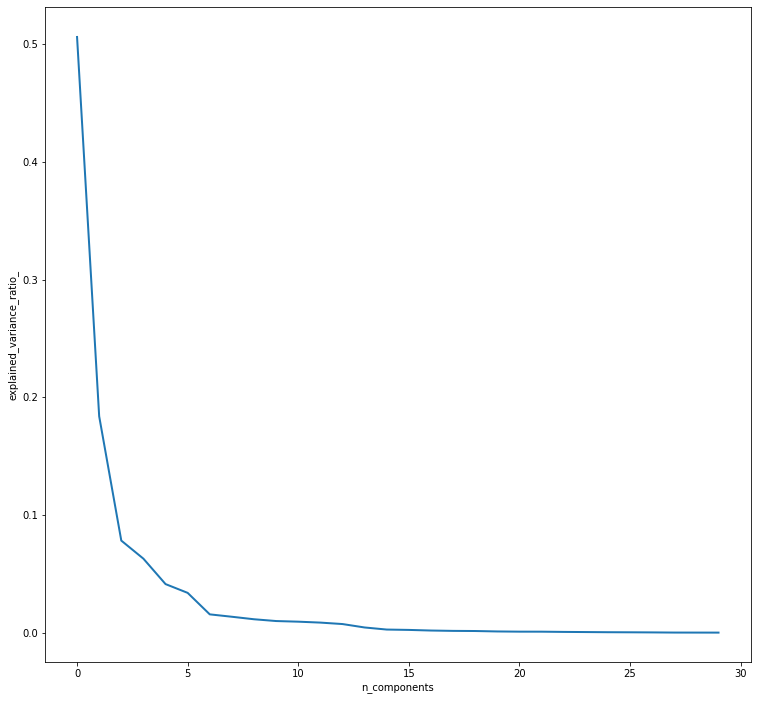

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#normalization
x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [72]:
data =df

In [73]:
from sklearn.manifold import  TSNE
dim_reduction = TSNE()
dims= dim_reduction.fit_transform(x,y)

In [74]:
data["diagnosis"].values.shape

(569,)

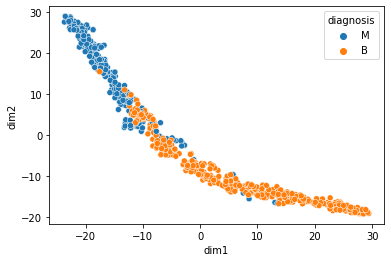

In [76]:
dim_reduction = TSNE(perplexity=50,n_iter=5000)
dims= dim_reduction.fit_transform(x,y)
rdims = pd.DataFrame(data={"dim1":dims[:,0].tolist(),
              "dim2":dims[:,1].tolist(),
              "diagnosis":data["diagnosis"].tolist()})
sns.scatterplot(data=rdims,x="dim1",y="dim2",hue ="diagnosis")

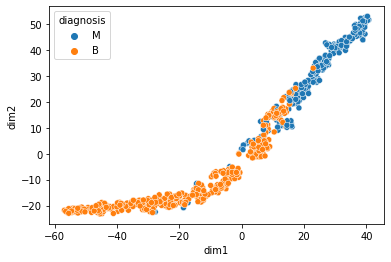

In [77]:
dim_reduction = TSNE(perplexity=30,n_iter=5000)
dims= dim_reduction.fit_transform(x,y)
rdims = pd.DataFrame(data={"dim1":dims[:,0].tolist(),
              "dim2":dims[:,1].tolist(),
              "diagnosis":data["diagnosis"].tolist()})
sns.scatterplot(data=rdims,x="dim1",y="dim2",hue ="diagnosis")

from the above graph we can say that,classification is possible with higher non-linear model